In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install stellargraph
import stellargraph as sg

!pip install networkx
import networkx as nx

!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Read in data 

Read in the data and split it into training and test datasets.

In [2]:
data_full = pd.read_csv('/content/drive/MyDrive/AI Dissertation /data/bs140513_032310.csv')
data_full["index"] = data_full.index
# add a column to data for customer id and merchant id with prefix 1: C and 2: M
data_full['merchant_id'] = data_full['merchant'].str.replace("M", '2').str.replace("'", "")
data_full['customer_id'] = data_full['customer'].str.replace("C", '1').str.replace("'", "")
data_full['category'] = data_full['category'].str.replace("'", "")
data_full['age'] = data_full['age'].str.replace("'", "")

category_oh = pd.get_dummies(data_full['category'], prefix='category')
data_full = data_full.join(category_oh)

age_oh = pd.get_dummies(data_full['age'], prefix='age')
data_full = data_full.join(age_oh)

def split_data(data, split_start, split_end):
    return data.loc[(data['step'] >= split_start) & (data['step'] <= split_end)]

data_train = split_data(data_full, 0, 28)
data_test = split_data(data_full, 29, 36)

print(data_test)


        step       customer age gender zipcodeOri       merchant zipMerchant  \
77596     29   'C604267980'   3    'F'    '28007'  'M1535107174'     '28007'   
77597     29   'C604267980'   3    'F'    '28007'  'M1198415165'     '28007'   
77598     29   'C672742304'   4    'M'    '28007'   'M348934600'     '28007'   
77599     29  'C1899001756'   2    'M'    '28007'  'M1823072687'     '28007'   
77600     29   'C255691679'   2    'F'    '28007'   'M692898500'     '28007'   
...      ...            ...  ..    ...        ...            ...         ...   
101104    36  'C1663641926'   6    'F'    '28007'  'M1823072687'     '28007'   
101105    36  'C1376617526'   3    'F'    '28007'  'M1823072687'     '28007'   
101106    36   'C617723960'   4    'F'    '28007'    'M50039827'     '28007'   
101107    36   'C704456922'   2    'M'    '28007'    'M50039827'     '28007'   
101108    36   'C426128777'   3    'F'    '28007'   'M348934600'     '28007'   

                    category  amount  f

## Nodes and their features

Take the customer id as the customer nodes. Age and gender are customer node features.

Take the merchant id as the merchant nodes. There are no merchant node features.

Take the index of the pandas dataset as the transaction nodes. Transaction category and amount are transaction node features. 

In [3]:
#node_customers = pd.DataFrame([1]*len(data_train.customer_id.unique())).set_index(data_train.customer_id.unique())
node_customers = data_train[["step", "customer_id", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U"]].drop_duplicates(subset=["customer_id"]).set_index("customer_id")
node_merchants = pd.DataFrame([1]*len(data_train.merchant_id.unique())).set_index(data_train.merchant_id.unique())

# transaction node data
node_txns = data_train[["step", "amount", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty", "index"]]
print(node_customers)

             step  age_0  age_1  age_2  age_3  age_4  age_5  age_6  age_U
customer_id                                                              
11093826151     0      0      0      0      0      1      0      0      0
1352968107      0      0      0      1      0      0      0      0      0
12054744914     0      0      0      0      0      1      0      0      0
11760612790     0      0      0      0      1      0      0      0      0
1757503768      0      0      0      0      0      0      1      0      0
...           ...    ...    ...    ...    ...    ...    ...    ...    ...
1417650106     28      0      0      0      1      0      0      0      0
11813823560    28      0      0      0      1      0      0      0      0
11726895756    28      0      0      0      0      0      1      0      0
1910454738     28      0      0      0      0      1      0      0      0
11501096176    28      0      0      0      0      0      1      0      0

[3949 rows x 9 columns]


## Edges 

Take the customer id and index to form edges.

Take the index and merchant to form edges.

In [4]:
### edges
# customer to transaction edges
edge_customer = data_train[["customer_id", "index"]]

# transaction to merchant edges
edge_merchant = data_train[["index", "merchant_id"]]


In [5]:
import sys
sys.path.append('/content/drive/MyDrive')

from inductiveGRL.graphconstruction import GraphConstruction

nodes = {"customer":data_train.customer_id, "merchant":data_train.merchant_id, "transaction":data_train.index}
edges = [zip(edge_customer.customer_id, edge_customer.index),zip(edge_merchant.index, edge_merchant.merchant_id)]
features = {"transaction": node_txns, 'customer': node_customers, 'merchant': node_merchants}
#print(node_customers)
#print(node_merchants)

graph = GraphConstruction(nodes, edges, features)
S = graph.get_stellargraph()
print(S.info())


StellarGraph: Undirected multigraph
 Nodes: 81595, Edges: 155192

 Node types:
  transaction: [77596]
    Features: float32 vector, length 13
    Edge types: transaction-default->customer, transaction-default->merchant
  customer: [3949]
    Features: float32 vector, length 9
    Edge types: customer-default->transaction
  merchant: [50]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction

 Edge types:
    merchant-default->transaction: [77596]
        Weights: all 1 (default)
        Features: none
    customer-default->transaction: [77596]
        Weights: all 1 (default)
        Features: none


# Train HinSage

In [6]:
from inductiveGRL.hinsage import HinSAGE_Representation_Learner

#GraphSAGE parameters
#num_samples = [2,32]
num_samples = [2, 5]
embedding_node_type = "transaction"

hinsage = HinSAGE_Representation_Learner(embedding_size=64, num_samples=num_samples, embedding_for_node_type=embedding_node_type)
trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(data_train.index), data_train['fraud'], batch_size=5, epochs=5)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
12416/12416 [==============================] - 78s 6ms/step - loss: 0.0587 - val_loss: 0.0218
Epoch 2/5
12416/12416 [==============================] - 63s 5ms/step - loss: 0.0296 - val_loss: 0.0234
Epoch 3/5
12416/12416 [==============================] - 64s 5ms/step - loss: 0.0272 - val_loss: 0.0276
Epoch 4/5
12416/12416 [==============================] - 65s 5ms/step - loss: 0.0257 - val_loss: 0.0201
Epoch 5/5
15520/15520 [==============================] - 53s 3ms/step


# Inductive Step

We want to keep the original indices after concatenating the train and inductive data, because they represent the transaction node ids. We need to concatenate these dataframes in order to easily construct the new graph.

In [7]:
pd.options.mode.chained_assignment = None

#data_train['index'] = data_train.index
#data_test['index'] = data_test.index
inductive_graph_data = pd.concat((data_train, data_test))
#inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index']).drop("index",axis = 1)

print(inductive_graph_data)

        step       customer age gender zipcodeOri       merchant zipMerchant  \
0          0  'C1093826151'   4    'M'    '28007'   'M348934600'     '28007'   
1          0   'C352968107'   2    'M'    '28007'   'M348934600'     '28007'   
2          0  'C2054744914'   4    'F'    '28007'  'M1823072687'     '28007'   
3          0  'C1760612790'   3    'M'    '28007'   'M348934600'     '28007'   
4          0   'C757503768'   5    'M'    '28007'   'M348934600'     '28007'   
...      ...            ...  ..    ...        ...            ...         ...   
101104    36  'C1663641926'   6    'F'    '28007'  'M1823072687'     '28007'   
101105    36  'C1376617526'   3    'F'    '28007'  'M1823072687'     '28007'   
101106    36   'C617723960'   4    'F'    '28007'    'M50039827'     '28007'   
101107    36   'C704456922'   2    'M'    '28007'    'M50039827'     '28007'   
101108    36   'C426128777'   3    'F'    '28007'   'M348934600'     '28007'   

                 category  amount  frau

For the inductive step, we need to add the new, unseen transactions to the graph. Because the current StellarGraph implementation does not support adding nodes and edges to an existing stellargraph object, we create a new graph that contains all the nodes from the train graph in addition to the new nodes.


In [8]:
def data_to_graph(dataset):
  ### nodes
  #node_customers = pd.DataFrame([1]*len(dataset.customer_id.unique())).set_index(dataset.customer_id.unique())
  node_customers = dataset[["step", "customer_id", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U"]].drop_duplicates(subset=["customer_id"]).set_index("customer_id")
  #print(node_customers.loc["1369566106"])
  node_merchants = pd.DataFrame([1]*len(dataset.merchant_id.unique())).set_index(dataset.merchant_id.unique())

  # transaction node data
  node_txns = dataset[["step", "amount", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", 
                       "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", 
                       "category_es_travel", "category_es_wellnessandbeauty", "index"]]

  ### edges
  # customer to transaction edges
  edge_customer = dataset[["customer_id", "index"]]

  # transaction to merchant edges
  edge_merchant = dataset[["index", "merchant_id"]]

  nodes = {"customer":dataset.customer_id, "merchant":dataset.merchant_id, "transaction":dataset.index}
  edges = [zip(edge_customer.customer_id, edge_customer.index),zip(edge_merchant.index, edge_merchant.merchant_id)]
  features = {"transaction": node_txns, 'customer': node_customers, 'merchant': node_merchants}

  graph = GraphConstruction(nodes, edges, features)
  S = graph.get_stellargraph()
  return S

#print(inductive_graph_data)
S_ind = data_to_graph(inductive_graph_data)
print(S_ind.info())

StellarGraph: Undirected multigraph
 Nodes: 105183, Edges: 202218

 Node types:
  transaction: [101109]
    Features: float32 vector, length 13
    Edge types: transaction-default->customer, transaction-default->merchant
  customer: [4024]
    Features: float32 vector, length 9
    Edge types: customer-default->transaction
  merchant: [50]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction

 Edge types:
    merchant-default->transaction: [101109]
        Weights: all 1 (default)
        Features: none
    customer-default->transaction: [101109]
        Weights: all 1 (default)
        Features: none


In [9]:
inductive_emb = hinsage.inductive_step_hinsage(S_ind, trained_hinsage_model, data_test.index, batch_size=5)

4703/4703 [==============================] - 16s 3ms/step


### 4. Classification: predictions based on inductive embeddings

Select your preferred classification model

In [10]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

If requested, the original transaction features are added to the generated embeddings. If these features are added, a baseline consisting of only these features (without embeddings) is included to analyze the net impact of embeddings on the predictive performance.

In [11]:
train_labels = data_train['fraud']

add_additional_data = True

if add_additional_data is True:
    train_emb_m = pd.merge(train_emb, data_train[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]], left_index=True, right_index=True)
    inductive_emb_m = pd.merge(inductive_emb, data_test[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]], left_index=True, right_index=True)

    #baseline_train = data_train.drop('fraud', axis=1)
    #baseline_inductive = data_test.drop('fraud', axis=1)
    baseline_train = data_train[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]]
    baseline_inductive = data_test[["amount", "age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_U", "category_es_home", "category_es_hotelservices", "category_es_hyper", "category_es_leisure", "category_es_otherservices", "category_es_sportsandtoys", "category_es_tech", "category_es_transportation", "category_es_travel", "category_es_wellnessandbeauty"]]

    classifier.fit(baseline_train, train_labels)
    baseline_predictions = classifier.predict_proba(baseline_inductive)

    classifier.fit(train_emb_m, train_labels)
    predictions = classifier.predict_proba(inductive_emb_m)
    
else:
  classifier.fit(train_emb, train_labels)
  predictions = classifier.predict_proba(inductive_emb)


### 5. Evaluation

Given the highly imbalanced nature of our dataset, we evaluate the results based on precision-recall curves. 

Average precision-recall score XGBoost: 0.8742355723
Average precision-recall score XGBoost: 0.8174838541


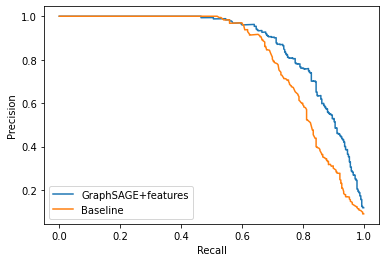

In [12]:
from inductiveGRL.evaluation import Evaluation
inductive_labels = data_full.loc[inductive_emb.index]['fraud']

graphsage_evaluation = Evaluation(predictions, inductive_labels, "GraphSAGE+features") 
graphsage_evaluation.pr_curve()

if add_additional_data is True:
    baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
    baseline_evaluation.pr_curve()

## Analysis of the overlap between graph and non-graph

## Baseline Confusion Matrix

Precision: 0.891213389121339
Recall: 0.665625


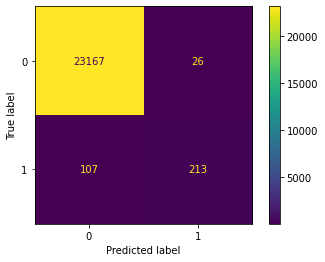

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

ConfusionMatrixDisplay.from_predictions(inductive_labels, np.argmax(baseline_predictions, axis=1))
print("Precision:", precision_score(inductive_labels, np.argmax(baseline_predictions, axis=1)))
print("Recall:", recall_score(inductive_labels, np.argmax(baseline_predictions, axis=1)))

## GraphSAGE+Features Confusion Matrix

Precision: 0.9336283185840708
Recall: 0.659375


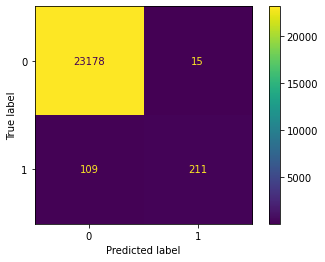

In [14]:
ConfusionMatrixDisplay.from_predictions(inductive_labels, np.argmax(predictions, axis=1))
print("Precision:", precision_score(inductive_labels, np.argmax(predictions, axis=1)))
print("Recall:", recall_score(inductive_labels, np.argmax(predictions, axis=1)))

## True Positive Overlap Analysis 


In [15]:
def tp_overlap_analysis(labels, baseline_predictions, graph_predictions, txn_data):
  baseline_tp = []
  graph_tp = []
  # get a list of baseline true positives and of graph true positives
  i=0
  for index, value in labels.items():
    # baseline true positives
    if value == baseline_predictions[i] and value == 1:
      baseline_tp.append(index)
    # graph true positives
    if value == graph_predictions[i] and value == 1:
      graph_tp.append(index)
    i = i+1 
  
  # compare id's from besline to graph true positives
  both_count = 0
  both_value = 0
  baseline_only_count = 0
  baseline_only_value = 0
  baseline_only_indexes = []
  for baseline_index in baseline_tp:
    if baseline_index in graph_tp:
      both_count += 1
      both_value += txn_data.loc[baseline_index, "amount"]
    else:
      baseline_only_count += 1
      baseline_only_value += txn_data.loc[baseline_index, "amount"]
      baseline_only_indexes.append(baseline_index)
  graph_only_count = 0
  graph_only_value = 0
  graph_only_indexes = []
  graph_both_count = 0
  for graph_index in graph_tp:
    if graph_index in baseline_tp:
      graph_both_count += 1
    else:
      graph_only_count += 1
      graph_only_value += txn_data.loc[graph_index, "amount"]
      graph_only_indexes.append(graph_index)
  return both_count, both_value, graph_both_count, graph_only_value, baseline_only_count, baseline_only_value, graph_only_count, baseline_only_indexes, graph_only_indexes

both_count, both_value, graph_both_count, graph_only_value, baseline_only_count, baseline_only_value, graph_only_count, baseline_only_indexes, graph_only_indexes = tp_overlap_analysis(inductive_labels, np.argmax(baseline_predictions, axis=1), np.argmax(predictions, axis=1), inductive_graph_data)

print("Number of overlapping transactions:", both_count)
print("Number of baseline only transactions:", baseline_only_count)
print("Number of GraphSAGE+features only transactions:", graph_only_count)
print()
total_TPs = both_count+baseline_only_count+graph_only_count
print("Total number of TP transactions identified:", total_TPs)
print("Percentage of overlapping transactions:", 100*both_count/total_TPs)
print("Percentage of baseline only transactions:", 100*baseline_only_count/total_TPs)
print("Percentage of GraphSAGE+Features only transactions:", 100*graph_only_count/total_TPs)
print()
print("Value of overlapping transactions:", both_value)
print("Value of baseline only transactions:", baseline_only_value)
print("Value of GraphSAGE+features transactions:", graph_only_value)
print()
total_value = both_value+baseline_only_value+graph_only_value
print("% Value of overlapping transactions:", 100*both_value/total_value)
print("% Value of baseline only transactions:", 100*baseline_only_value/total_value)
print("% Value of GraphSAGE+features transactions:", 100*graph_only_value/total_value)
print()
print("Average Value of overlapping transactions:", both_value/both_count)
print("Average Value of baseline only transactions:", baseline_only_value/baseline_only_count)
print("Average Value of GraphSAGE+features transactions:", graph_only_value/graph_only_count)

Number of overlapping transactions: 196
Number of baseline only transactions: 17
Number of GraphSAGE+features only transactions: 15

Total number of TP transactions identified: 228
Percentage of overlapping transactions: 85.96491228070175
Percentage of baseline only transactions: 7.456140350877193
Percentage of GraphSAGE+Features only transactions: 6.578947368421052

Value of overlapping transactions: 173627.6200000001
Value of baseline only transactions: 7026.530000000001
Value of GraphSAGE+features transactions: 2944.45

% Value of overlapping transactions: 94.56914159476162
% Value of baseline only transactions: 3.827115239440822
% Value of GraphSAGE+features transactions: 1.6037431657975594

Average Value of overlapping transactions: 885.8552040816332
Average Value of baseline only transactions: 413.3252941176471
Average Value of GraphSAGE+features transactions: 196.29666666666665


# Time analysis


In [23]:
graph_predictions = np.argmax(predictions, axis=1)
base_preds = np.argmax(baseline_predictions, axis=1)


# get a list of baseline true positives and of graph true positives
baseline_tp = []
baseline_time = []
graph_tp = []
graph_time = []
i=0
for index, value in inductive_labels.items():
  # baseline true positives
  if (value == base_preds[i]) and (value == 1):
    baseline_tp.append(index)
    baseline_time.append(inductive_graph_data.loc[index, "step"])
  # graph true positives
  if value == graph_predictions[i] and value == 1:
    graph_tp.append(index)
    graph_time.append(inductive_graph_data.loc[index, "step"])
  i = i+1 


for i in range(29,37):
  print("Baseline count", i, ":", baseline_time.count(i))
  print("GraphSAGE count", i, ":", graph_time.count(i))

Baseline count 29 : 28
GraphSAGE count 29 : 25
Baseline count 30 : 25
GraphSAGE count 30 : 24
Baseline count 31 : 29
GraphSAGE count 31 : 25
Baseline count 32 : 25
GraphSAGE count 32 : 25
Baseline count 33 : 29
GraphSAGE count 33 : 29
Baseline count 34 : 28
GraphSAGE count 34 : 31
Baseline count 35 : 26
GraphSAGE count 35 : 29
Baseline count 36 : 23
GraphSAGE count 36 : 23


# Changing the decision boundary


In [17]:
print(baseline_predictions[:,1])
#np.argmax(baseline_predictions, axis=1)

def classify_probabilities(prediction_probs, decision_boundary):
  pred_c = []
  for p in prediction_probs:
    if p > decision_boundary:
      pred_c.append(1)
    else:
      pred_c.append(0)
  return pred_c



[1.31355915e-02 1.40381187e-01 4.11182991e-05 ... 7.67907426e-02
 9.52800691e-01 4.35707261e-05]


## Baseline Confusion matrix

Precision: 0.8115942028985508
Recall: 0.7


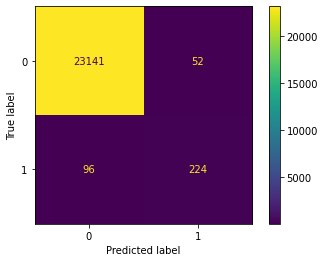

In [18]:
baseline_pred_c = classify_probabilities(baseline_predictions[:, 1], 0.35)
ConfusionMatrixDisplay.from_predictions(inductive_labels, baseline_pred_c)
print("Precision:", precision_score(inductive_labels, baseline_pred_c))
print("Recall:", recall_score(inductive_labels, baseline_pred_c))

# GraphSAGE Confusion Matrix

Precision: 0.7819314641744548
Recall: 0.784375


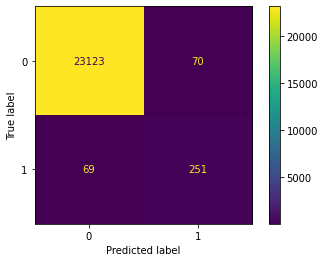

In [19]:
pred_c = classify_probabilities(predictions[:, 1], 0.22)
ConfusionMatrixDisplay.from_predictions(inductive_labels, pred_c)
print("Precision:", precision_score(inductive_labels, pred_c))
print("Recall:", recall_score(inductive_labels, pred_c))

## Overlap analysis

In [20]:
both_count, both_value, graph_both_count, graph_only_value, baseline_only_count, baseline_only_value, graph_only_count, baseline_only_indexes, graph_only_indexes = tp_overlap_analysis(inductive_labels, baseline_pred_c, pred_c, inductive_graph_data)

print("Number of overlapping transactions:", both_count)
print("Number of baseline only transactions:", baseline_only_count)
print("Number of GraphSAGE+features only transactions:", graph_only_count)
print()
total_TPs = both_count+baseline_only_count+graph_only_count
print("Total number of TP transactions identified:", total_TPs)
print("Percentage of overlapping transactions:", 100*both_count/total_TPs)
print("Percentage of baseline only transactions:", 100*baseline_only_count/total_TPs)
print("Percentage of GraphSAGE+Features only transactions:", 100*graph_only_count/total_TPs)
print()
print("Value of overlapping transactions:", both_value)
print("Value of baseline only transactions:", baseline_only_value)
print("Value of GraphSAGE+features transactions:", graph_only_value)
print()
total_value = both_value+baseline_only_value+graph_only_value
print("% Value of overlapping transactions:", 100*both_value/total_value)
print("% Value of baseline only transactions:", 100*baseline_only_value/total_value)
print("% Value of GraphSAGE+features transactions:", 100*graph_only_value/total_value)
print()
print("Average Value of overlapping transactions:", both_value/both_count)
print("Average Value of baseline only transactions:", baseline_only_value/baseline_only_count)
print("Average Value of GraphSAGE+features transactions:", graph_only_value/graph_only_count)

Number of overlapping transactions: 219
Number of baseline only transactions: 5
Number of GraphSAGE+features only transactions: 32

Total number of TP transactions identified: 256
Percentage of overlapping transactions: 85.546875
Percentage of baseline only transactions: 1.953125
Percentage of GraphSAGE+Features only transactions: 12.5

Value of overlapping transactions: 181959.8900000001
Value of baseline only transactions: 1585.51
Value of GraphSAGE+features transactions: 3754.1099999999997

% Value of overlapping transactions: 97.14915431439196
% Value of baseline only transactions: 0.8465104900701551
% Value of GraphSAGE+features transactions: 2.0043351955378834

Average Value of overlapping transactions: 830.8670776255713
Average Value of baseline only transactions: 317.102
Average Value of GraphSAGE+features transactions: 117.31593749999999


# Time step analysis

In [24]:
graph_predictions = pred_c
base_preds = baseline_pred_c


# get a list of baseline true positives and of graph true positives
baseline_tp = []
baseline_time = []
graph_tp = []
graph_time = []
i=0
for index, value in inductive_labels.items():
  # baseline true positives
  if (value == base_preds[i]) and (value == 1):
    baseline_tp.append(index)
    baseline_time.append(inductive_graph_data.loc[index, "step"])
  # graph true positives
  if value == graph_predictions[i] and value == 1:
    graph_tp.append(index)
    graph_time.append(inductive_graph_data.loc[index, "step"])
  i = i+1 


for i in range(29,37):
  print("Baseline count", i, ":", baseline_time.count(i))
  print("GraphSAGE count", i, ":", graph_time.count(i))

Baseline count 29 : 29
GraphSAGE count 29 : 33
Baseline count 30 : 26
GraphSAGE count 30 : 28
Baseline count 31 : 29
GraphSAGE count 31 : 29
Baseline count 32 : 25
GraphSAGE count 32 : 33
Baseline count 33 : 29
GraphSAGE count 33 : 33
Baseline count 34 : 30
GraphSAGE count 34 : 32
Baseline count 35 : 28
GraphSAGE count 35 : 32
Baseline count 36 : 28
GraphSAGE count 36 : 31
